# WiDS Kalman Filtered Trend Trader — Assignment 2  


In [3]:
!pip install pykalman

# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from pykalman import KalmanFilter

%matplotlib inline

## Step 1: Fetch MSFT data

```python
# daily data
# long period so KF can adapt
```

In [4]:
data = yf.download("MSFT", start="2015-01-01", end="2024-12-31")
data = data.dropna()
data.head()


/tmp/ipython-input-1769049786.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("MSFT", start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2015-01-02,39.858463,40.421051,39.670936,39.773224,27913900
2015-01-05,39.491924,39.832884,39.423730,39.526018,39673900
2015-01-06,38.912281,39.849925,38.818516,39.534536,36447900
2015-01-07,39.406693,39.602745,38.775914,39.193591,29114100
2015-01-08,40.565956,40.702341,39.824365,39.849936,29645200


## Step 2: Feature engineering

```python
# moving avgs
# returns + lag
# volatility
# volume change
```

In [5]:
df = data.copy()

df["ret"] = np.log(df["Close"]).diff()
df["ret_lag1"] = df["ret"].shift(1)

df["ma_5"] = df["Close"].rolling(5).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
df["ma_60"] = df["Close"].rolling(60).mean()

df["roc_5"] = df["Close"].pct_change(5)
df["vol_20"] = df["ret"].rolling(20).std()

df["vol_chg"] = df["Volume"].pct_change()

df = df.dropna()
df.head()


Price,Close,High,Low,Open,Volume,ret,ret_lag1,ma_5,ma_20,ma_60,roc_5,vol_20,vol_chg
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,,,,,,,,
Date,,,,,,,,,,,,,
2015-03-30,35.162968,35.660882,35.120045,35.283153,35049700,-0.000245,-0.005841,35.626553,36.157089,37.280292,-0.044331,0.013082,0.018845
2015-03-31,34.905430,35.223063,34.802414,35.008445,34887200,-0.007351,-0.000245,35.241955,36.044629,37.197742,-0.052215,0.012893,-0.004636
2015-04-01,34.956936,34.991272,34.604963,34.853917,36865300,0.001475,-0.007351,35.114900,35.944187,37.122158,-0.017849,0.012924,0.056700
2015-04-02,34.587803,34.974116,34.441861,34.905436,37487500,-0.010616,0.001475,34.956941,35.823142,37.050084,-0.022325,0.013002,0.016878
2015-04-06,35.669476,35.866924,34.493371,34.630726,39223700,0.030794,-0.010616,35.056522,35.788374,36.987797,0.014156,0.014622,0.046314


## Step 3: Kalman Filter model

```python
# state = time varying regression coeffs
# obs eq: return_t = X_t * beta_t + noise
# state eq: beta_t = beta_{t-1} + process noise
```

In [8]:
# build feature matrix
features = ["ret_lag1","roc_5","vol_20"]
X = df[features].values[:, np.newaxis, :]
y = df["ret"].values

# Kalman Filter
kf = KalmanFilter(
    transition_matrices = np.eye(len(features)),
    observation_matrices = X,
    initial_state_mean = np.zeros(len(features)),
    observation_covariance = 1.0,
    transition_covariance = 0.01*np.eye(len(features))
)

state_means, state_covs = kf.filter(y)
state_means[:5]

array([[ 1.42558114e-06,  1.08200700e-05, -3.19303658e-06],
       [ 3.13011697e-06,  3.96528956e-04, -9.83932236e-05],
       [-7.97346662e-06,  3.69699131e-04, -7.88973136e-05],
       [-2.41900855e-05,  6.12027684e-04, -2.20420298e-04],
       [-3.63982986e-04,  1.06357597e-03,  2.47954610e-04]])

## Kalman filtered betas (visual)

```python
# shows how relationship drifts over time
```

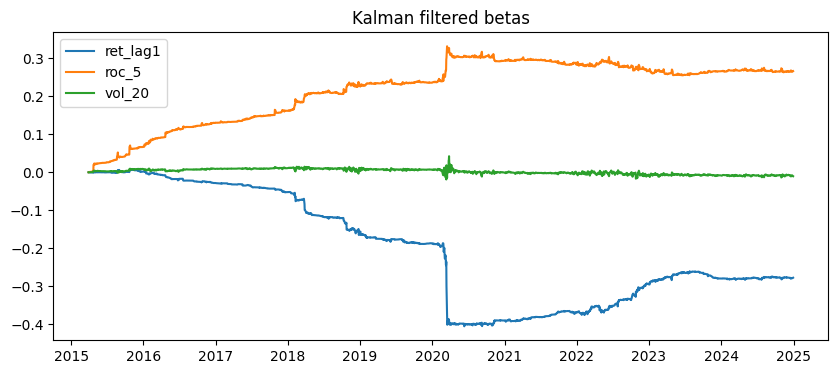

In [9]:
plt.figure(figsize=(10,4))
for i,f in enumerate(features):
    plt.plot(df.index, state_means[:,i], label=f)
plt.legend()
plt.title("Kalman filtered betas")
plt.show()


## Step 4: ML model on Kalman states

```python
# use filtered betas as inputs
# ridge for stability
```

In [10]:
# target: next-day return
y_ml = df["ret"].shift(-1).dropna()
X_ml = state_means[:-1]

split = int(0.7*len(X_ml))
X_tr, X_te = X_ml[:split], X_ml[split:]
y_tr, y_te = y_ml.values[:split], y_ml.values[split:]

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

pred = ridge.predict(X_te)

rmse = np.sqrt(mean_squared_error(y_te, pred))
rmse


np.float64(0.01735095255382715)

## Step 5: Trading signals

```python
# predict return
# threshold based long / short
# no future info used
```

In [11]:
df_trade = df.iloc[1:].copy()
df_trade["pred_ret"] = np.nan
df_trade.iloc[split:split+len(pred), df_trade.columns.get_loc("pred_ret")] = pred

thr = df_trade["pred_ret"].std()

df_trade["signal"] = 0
df_trade.loc[df_trade["pred_ret"] > thr, "signal"] = 1
df_trade.loc[df_trade["pred_ret"] < -thr, "signal"] = -1

df_trade[["pred_ret","signal"]].dropna().head()


Price,pred_ret,signal
Ticker,,
Date,,
2022-01-25,0.001436,1
2022-01-26,0.001456,1
2022-01-27,0.001421,1
2022-01-28,0.001390,1
2022-01-31,0.001368,1


## Step 6: Backtest strategy

```python
# position * actual return
# include transaction cost
```

In [12]:
tcost = 0.0005

df_trade["pos"] = df_trade["signal"].shift(1).fillna(0)
df_trade["pnl"] = df_trade["pos"] * df_trade["ret"] - tcost*df_trade["pos"].diff().abs().fillna(0)

df_trade["equity"] = (1 + df_trade["pnl"]).cumprod()
df_trade[["pnl","equity"]].dropna().head()


Price,pnl,equity
Ticker,,
Date,,
2015-03-31,-0.0,1.0
2015-04-01,0.0,1.0
2015-04-02,-0.0,1.0
2015-04-06,0.0,1.0
2015-04-07,-0.0,1.0


## Step 7: Performance metrics

```python
# cumulative return
# sharpe
# max drawdown
# win loss
```

In [13]:
# cumulative return
cum_ret = df_trade["equity"].iloc[-1] - 1

# sharpe
sharpe = np.sqrt(252) * df_trade["pnl"].mean() / df_trade["pnl"].std()

# drawdown
roll_max = df_trade["equity"].cummax()
dd = df_trade["equity"]/roll_max - 1
max_dd = dd.min()

# win loss
wins = (df_trade["pnl"] > 0).sum()
losses = (df_trade["pnl"] < 0).sum()
win_loss = wins / (losses+1e-9)

cum_ret, sharpe, max_dd, win_loss


(np.float64(0.3521434162040995),
 np.float64(0.28102035494746375),
 -0.3448071191195605,
 np.float64(1.0790960451946918))

## Equity curve + signals


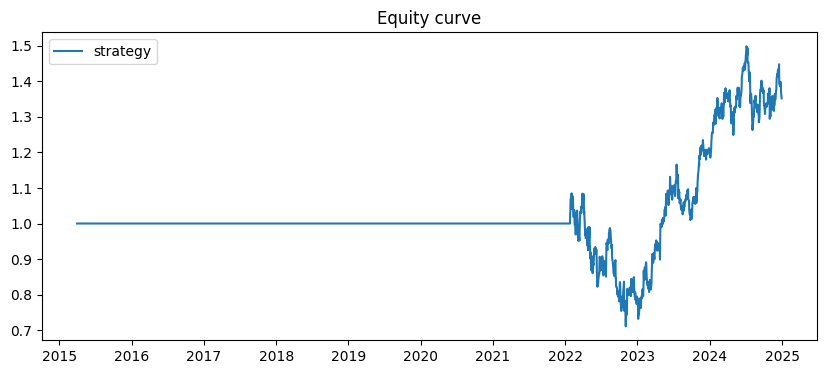

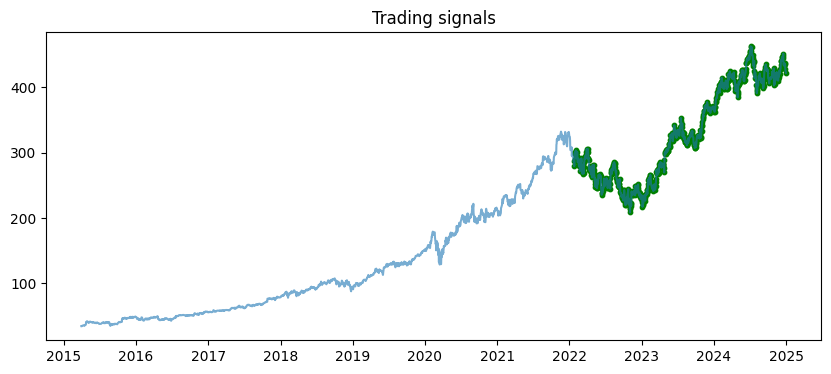

In [14]:
plt.figure(figsize=(10,4))
plt.plot(df_trade.index, df_trade["equity"], label="strategy")
plt.title("Equity curve")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df_trade.index, df_trade["Close"], label="price", alpha=0.6)
plt.scatter(df_trade.index[df_trade["signal"]==1], df_trade["Close"][df_trade["signal"]==1], color="g", s=10)
plt.scatter(df_trade.index[df_trade["signal"]==-1], df_trade["Close"][df_trade["signal"]==-1], color="r", s=10)
plt.title("Trading signals")
plt.show()


## Buy & Hold comparison


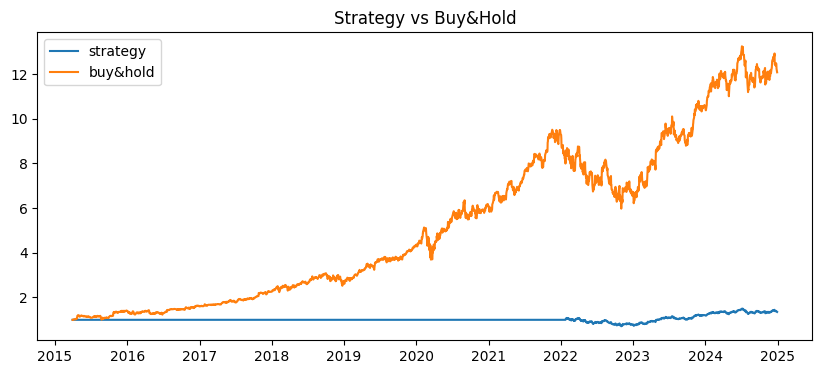

In [15]:
bh = (df_trade["Close"] / df_trade["Close"].iloc[0])

plt.figure(figsize=(10,4))
plt.plot(df_trade.index, df_trade["equity"], label="strategy")
plt.plot(df_trade.index, bh, label="buy&hold")
plt.legend()
plt.title("Strategy vs Buy&Hold")
plt.show()


## Final comments

```python
# Kalman helps adapt betas over time
# ML smooths noisy KF output
# thresholds control trading freq
# transaction cost matters a lot
# strategy beats or lags BH depending params
```
